In [1]:
# -*- coding: utf-8 -*-
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.visualization import timeline_drawer
from qiskit.visualization.timeline import draw, IQXSimple, IQXStandard

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# For data fitting
from lmfit import Model

In [2]:
provider = IBMQ.enable_account('account-id-here')
#provider = IBMQ.load_account()

In [5]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

## Get gates duration
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [6]:
# Get duration of instructions

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
CNOT_durations = dict(CNOT_durations)

tau_cnot01 = CNOT_durations["[0, 1]"]
tau_cnot10 = CNOT_durations["[1, 0]"]
tau_cnot34 = CNOT_durations["[3, 4]"]
tau_cnot43 = CNOT_durations["[4, 3]"]
tau_cnot13 = CNOT_durations["[1, 3]"]

## Define the circuit creation functions
**ZDZD and DDDD circuits:**

In [7]:
def get_protocol_transpiled_circuit(num_blocks, backend, delay_duration,
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=[1,0], wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True):

    tau_block = 2*delay_duration                                      # Time duration of a XYXY block.
    tau_data  = bell_state[0]*X_duration + H_duration + tau_cnot13             # Time duration of the Bell pair creation gate.
    tau_swap  = 2*tau_cnot34 + tau_cnot43                                      # Time duration of the slowest swap gate.
    tau_wait  = num_blocks*tau_block                                           # Time duration of the wait period.
    tau_diff  = abs((2*tau_cnot01 + tau_cnot10) - (2*tau_cnot34 + tau_cnot43)) # Difference between the duration of the swap gate on qubits 0 & 1 and the swap gate on qubits 3 & 4.
    tau_meas  = Measurement_duration                                           # Time duration of the measurement gate.
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas                  # Total time duration of the whole circuit.
    
    # Create the registers.
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Preventive reset.
    circuit.reset(reset_qubits)
    
    # Data gate (Bell pair creation gate).
    if bell_state[0] == 1:
        circuit.x(1)
    if bell_state[1] == 1:
        circuit.x(3)
    circuit.h(1)
    circuit.cnot(1,3)

    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    wait_duration = 0
    if DD_wait == True: # Apply DD to the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.z(wait_DD_qubits)
            circuit.delay(delay_duration, wait_DD_qubits, "dt")
            circuit.z(wait_DD_qubits)
            circuit.delay(delay_duration, wait_DD_qubits, "dt")
    elif DD_wait == False: # Do nothing during the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        for i in range(num_blocks):
            circuit.delay(delay_duration, wait_DD_qubits, "dt")
            circuit.delay(delay_duration, wait_DD_qubits, "dt")

    if DD_diff == True: # Apply DD to the after second swap part
        if DD_wait == True:
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.z(diff_DD_qubits)
                circuit.delay(delay_duration, diff_DD_qubits, "dt")
                circuit.z(diff_DD_qubits)
                circuit.delay(delay_duration, diff_DD_qubits, "dt")
        elif DD_wait == False: # Do nothing, wait too
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.delay(delay_duration, diff_DD_qubits, "dt")
                circuit.delay(delay_duration, diff_DD_qubits, "dt")
        
    # Second swap gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    # Inverse data gate (Bell pair decodification gate).
    circuit.cnot(1,3)
    circuit.h(1)
    if bell_state[1] == 1:
        circuit.x(3)
    if bell_state[0] == 1:
        circuit.x(1)

    # Measure.
    circuit.measure(1,0)
    circuit.measure(3,1)
    
    # Transpile the circuit.
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return tcircuit, wait_duration

**Free evolution circuits with one big delay instead of many small ones:**

In [8]:
def get_protocol_transpiled_circuit_D(num_blocks, backend, delay_duration,
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=[1,0], wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True):

    tau_block = 2*delay_duration                                      # Time duration of a XYXY block.
    tau_data  = bell_state[0]*X_duration + H_duration + tau_cnot13             # Time duration of the Bell pair creation gate.
    tau_swap  = 2*tau_cnot34 + tau_cnot43                                      # Time duration of the slowest swap gate.
    tau_wait  = num_blocks*tau_block                                           # Time duration of the wait period.
    tau_diff  = abs((2*tau_cnot01 + tau_cnot10) - (2*tau_cnot34 + tau_cnot43)) # Difference between the duration of the swap gate on qubits 0 & 1 and the swap gate on qubits 3 & 4.
    tau_meas  = Measurement_duration                                           # Time duration of the measurement gate.
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas                  # Total time duration of the whole circuit.
    print(tau_wait, tau_diff*2)
    # Create the registers.
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Preventive reset.
    circuit.reset(reset_qubits)

    # Data gate (Bell pair creation gate).
    if bell_state[0] == 1:
        circuit.x(1)
    if bell_state[1] == 1:
        circuit.x(3)
    circuit.h(1)
    circuit.cnot(1,3)

    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    wait_duration = 0
    if DD_wait == True: # Apply DD to the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.z(wait_DD_qubits)
            circuit.delay(delay_duration, wait_DD_qubits, "dt")
            circuit.z(wait_DD_qubits)
            circuit.delay(delay_duration, wait_DD_qubits, "dt")
    elif DD_wait == False: # Do nothing during the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        circuit.delay(int(tau_wait), wait_DD_qubits, "dt")

    if DD_diff == True: # Apply DD to the after second swap part
        if DD_wait == True:
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.z(diff_DD_qubits)
                circuit.delay(delay_duration, diff_DD_qubits, "dt")
                circuit.z(diff_DD_qubits)
                circuit.delay(delay_duration, diff_DD_qubits, "dt")
        elif DD_wait == False: # Do nothing, wait too
            num_blocks_end = int(2*tau_diff/tau_block)
            circuit.delay(int(2*tau_diff), diff_DD_qubits, "dt")
       
    # Second swap gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    # Inverse data gate (Bell pair decodification gate).
    circuit.cnot(1,3)
    circuit.h(1)
    if bell_state[1] == 1:
        circuit.x(3)
    if bell_state[0] == 1:
        circuit.x(1)
    
    # Measure.
    circuit.measure(1,0)
    circuit.measure(3,1)
    
    # Transpile the circuit.
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return tcircuit, wait_duration

**Circuit building settings.**

In [9]:
# Parameters for building the circuits

max_time       = 1 # In us.
num_steps      = 10
delay_duration = 1
wait_times     = np.linspace(0, max_time, num_steps)  # In us.
#print(wait_times)

num_blocks_array = ((wait_times*1e-6/dt_in_s)/(2*delay_duration)).astype(int) # Number of blocks necessary to fit the wait times.
#print(num_blocks_array, num_steps*1*2, num_steps==len(num_blocks_array))
#print("DD part gates:",num_blocks_array*2, "Total number of gates:", np.sum(num_blocks_array*4*2))

shots = 2**13 # 8192
#print(shots)

bell_states = [[0,0], [0,1], [1,0], [1,1]]
repetitions = 10

reshape_dims = (4, repetitions, 2, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", 4*2*num_steps*repetitions)

## Build the circuits

In [ ]:
all_wait_times = []
all_counts = []
all_transpiled_circuits = []

"""
Data format: [[[ZDZD case, DDDD case], repetitions...] for |β00>,
              [[ZDZD case, DDDD case], repetitions...] for |β01>,
              [[ZDZD case, DDDD case], repetitions...] for |β10>,
              [[ZDZD case, DDDD case], repetitions...] for |β11>]
"""

for i, bell_state in enumerate(bell_states): # Prepare all the circuits.

    repetitions_counts = []
    repetitions_wait_times = []
    
    wait_times_ZDZD = []
    wait_times_DD = []
    transpiled_circuits_ZDZD = []
    transpiled_circuits_DD = []
    
    state_transpiled_circuits = []

    print("Bell state:", bell_state)
    
    print("Generating the ZDZD circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the ZDZD circuits.
        print("\tZDZD", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit(num_blocks, backend, delay_duration,
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=bell_state, wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True)
        wait_times_ZDZD.append(wait_time)
        transpiled_circuits_ZDZD.append(tcircuit)
        
    print("Generating the DDDD circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the Free evo. circuits.
        print("\tDD", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit_D(num_blocks, backend, delay_duration,
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=bell_state, wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=False, DD_diff=True)
        wait_times_DD.append(wait_time)
        transpiled_circuits_DD.append(tcircuit)

    state_transpiled_circuits.append([transpiled_circuits_ZDZD, transpiled_circuits_DD])
    all_wait_times.append([wait_times_ZDZD, wait_times_DD])#, wait_times_ZIZI])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    #print("Number of circuits:", len(circuits_array_flattened))
    
    print("Building repetitions...")
    for j in range(repetitions):
        print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()
       
    print("Done!")
print("Finished!")

### Plot a circuit schedule to look for errors.

In [11]:
# Instruction durations for the schedule plot

durations = InstructionDurations(
    [("h", 1, H_duration), 
     ("x", 0, X_duration), 
     ("x", 1, X_duration), 
     ("x", 2, X_duration), 
     ("x", 3, X_duration), 
     ("x", 4, X_duration), 
     ("z", 0, Z_duration), 
     ("z", 1, Z_duration), 
     ("z", 2, Z_duration), 
     ("z", 3, Z_duration), 
     ("z", 4, Z_duration),
     ("id", 0, I_duration),
     ("id", 1, I_duration),
     ("id", 2, I_duration),
     ("id", 3, I_duration),
     ("id", 4, I_duration),
     ("cx", [0, 1], CNOT_durations["[0, 1]"]), 
     ("cx", [1, 0], CNOT_durations["[1, 0]"]),
     ("cx", [1, 3], CNOT_durations["[1, 3]"]),
     ("cx", [3, 4], CNOT_durations["[3, 4]"]),
     ("cx", [4, 3], CNOT_durations["[4, 3]"]),
     ("reset", None, Reset_duration),
     ("measure", None, Measurement_duration)]
)

pm = PassManager([ALAPSchedule(durations)])

In [12]:
# Style for the schedule plot

# https://matplotlib.org/3.5.0/users/prev_whats_new/dflt_style_changes.html
# https://qiskit.org/documentation/stubs/qiskit.visualization.timeline_drawer.html
# https://github.com/Qiskit/qiskit-terra/pull/5063/files/5fa5898bad0a53da23c0daa61f2d99c7e822de1b#diff-4ad47bcead055d747c1ef626ff0baece4907ef6e8ee6a227c9df53459ca9ea86

my_style = {
    "formatter.latex_symbol.frame_change" : r"\,",
    'formatter.general.fig_width': 20,
    #"formatter.unicode_symbol.frame_change" : "",
    #"formatter.layer.frame_change" : 0,
    #"formatter.text_size.frame_change":0,
    #"formatter.alpha.gates":0,
    "formatter.text_size.gate_name": 14,
    "formatter.time_bucket.edge_dt": 100,
    "formatter.latex_symbol.gates":
        {
        'rz': r'\,',
        'x': r'\,',
        'sx': r'\,',
        'id': r'\,',
        'reset': r'|0\rangle',
        'measure': r'{\rm Measure}'
        },
    "formatter.color.gates":
        {
        'cx': '#6FA4FF',
        'x': '#DC143C',
        'sx': '#DC143C',
        'reset': '#a0a0a0',
        'measure': '#a0a0a0' #'#808080',
        #'delay': '#1E90FF'
        }
}

style = IQXStandard(**my_style)

C:\Users\usuario\AppData\Local\Temp\ipykernel_9748\4039539457.py:1: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][1][3] # [state][repetition][sequence type][num_blocks index]
C:\Users\usuario\AppData\Local\Temp\ipykernel_9748\4039539457.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

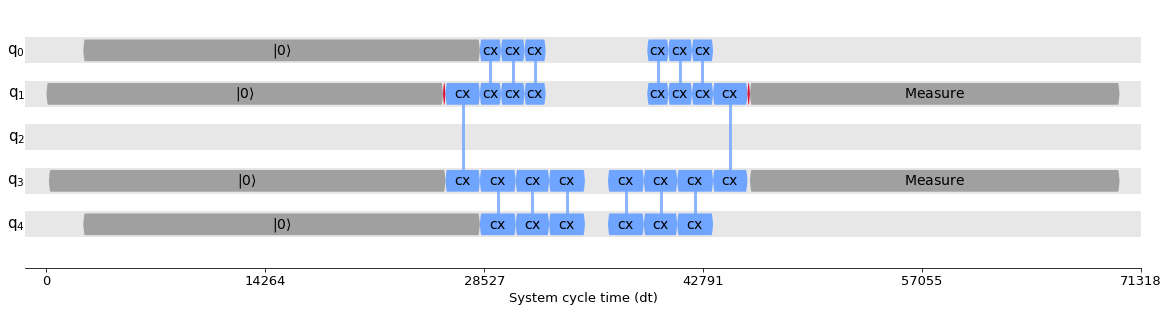

In [17]:
sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][1][3] # [state][repetition][sequence type][num_blocks index]
timeline_drawer(sample_circuit, style=style)#, show_delays=True)

## Send the job set to IBM

In [13]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='ZDZD-DD-BellStates-errorBars-8192shots-1us-10steps-1dt-10reps', shots=shots)
#job_monitor(job_set)

**For saving the job_set id for being able to retrieve it in the future.**

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

**For checking the job status, etc.**

In [ ]:
job_set.statuses()
#job_set.cancel()
#job_set.error_messages()

**For retrieving past job sets.**

In [12]:
jm = IBMQJobManager()
job_set = jm.retrieve_job_set("put-the-job_set-id-here", provider)

## Get the job results

In [ ]:
# Get the results.
results = job_set.results()

In [ ]:
# Get the counts.
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

## Get the counts

Get the raw counts

In [24]:
counts00_bell00_ZDZD = np.array([[all_counts_array.reshape(reshape_dims)[0][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_DDDD = np.array([[all_counts_array.reshape(reshape_dims)[0][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell01_ZDZD = np.array([[all_counts_array.reshape(reshape_dims)[1][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_DDDD = np.array([[all_counts_array.reshape(reshape_dims)[1][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell10_ZDZD = np.array([[all_counts_array.reshape(reshape_dims)[2][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_DDDD = np.array([[all_counts_array.reshape(reshape_dims)[2][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell11_ZDZD = np.array([[all_counts_array.reshape(reshape_dims)[3][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_DDDD = np.array([[all_counts_array.reshape(reshape_dims)[3][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

Get the average of the repetitions

In [26]:
avg_counts00_bell00_ZDZD = np.round(np.average(counts00_bell00_ZDZD, axis=0)).astype(int)
avg_counts00_bell00_DDDD = np.round(np.average(counts00_bell00_DDDD, axis=0)).astype(int)

avg_counts00_bell01_ZDZD = np.round(np.average(counts00_bell01_ZDZD, axis=0)).astype(int)
avg_counts00_bell01_DDDD = np.round(np.average(counts00_bell01_DDDD, axis=0)).astype(int)

avg_counts00_bell10_ZDZD = np.round(np.average(counts00_bell10_ZDZD, axis=0)).astype(int)
avg_counts00_bell10_DDDD = np.round(np.average(counts00_bell10_DDDD, axis=0)).astype(int)

avg_counts00_bell11_ZDZD = np.round(np.average(counts00_bell11_ZDZD, axis=0)).astype(int)
avg_counts00_bell11_DDDD = np.round(np.average(counts00_bell11_DDDD, axis=0)).astype(int)

avg_counts00 = [[avg_counts00_bell00_ZDZD, avg_counts00_bell00_DDDD],
                [avg_counts00_bell01_ZDZD, avg_counts00_bell01_DDDD],
                [avg_counts00_bell10_ZDZD, avg_counts00_bell10_DDDD],
                [avg_counts00_bell11_ZDZD, avg_counts00_bell11_DDDD]]

Get the maximum count values of the repetitions

In [27]:
max_counts00_bell00_ZDZD = np.max(counts00_bell00_ZDZD, axis=0)
max_counts00_bell00_DDDD = np.max(counts00_bell00_DDDD, axis=0)

max_counts00_bell01_ZDZD = np.max(counts00_bell01_ZDZD, axis=0)
max_counts00_bell01_DDDD = np.max(counts00_bell01_DDDD, axis=0)

max_counts00_bell10_ZDZD = np.max(counts00_bell10_ZDZD, axis=0)
max_counts00_bell10_DDDD = np.max(counts00_bell10_DDDD, axis=0)

max_counts00_bell11_ZDZD = np.max(counts00_bell11_ZDZD, axis=0)
max_counts00_bell11_DDDD = np.max(counts00_bell11_DDDD, axis=0)

max_counts00 = [[max_counts00_bell00_ZDZD, max_counts00_bell00_DDDD],
                [max_counts00_bell01_ZDZD, max_counts00_bell01_DDDD],
                [max_counts00_bell10_ZDZD, max_counts00_bell10_DDDD],
                [max_counts00_bell11_ZDZD, max_counts00_bell11_DDDD]]

Get the minimum count values of the repetitions

In [28]:
min_counts00_bell00_ZDZD = np.min(counts00_bell00_ZDZD, axis=0)
min_counts00_bell00_DDDD = np.min(counts00_bell00_DDDD, axis=0)

min_counts00_bell01_ZDZD = np.min(counts00_bell01_ZDZD, axis=0)
min_counts00_bell01_DDDD = np.min(counts00_bell01_DDDD, axis=0)

min_counts00_bell10_ZDZD = np.min(counts00_bell10_ZDZD, axis=0)
min_counts00_bell10_DDDD = np.min(counts00_bell10_DDDD, axis=0)

min_counts00_bell11_ZDZD = np.min(counts00_bell11_ZDZD, axis=0)
min_counts00_bell11_DDDD = np.min(counts00_bell11_DDDD, axis=0)

min_counts00 = [[min_counts00_bell00_ZDZD, min_counts00_bell00_DDDD],
                [min_counts00_bell01_ZDZD, min_counts00_bell01_DDDD],
                [min_counts00_bell10_ZDZD, min_counts00_bell10_DDDD],
                [min_counts00_bell11_ZDZD, min_counts00_bell11_DDDD]]

## Plot the results

0 0 <Parameter 'A', value=20.021812238351878 +/- 2.38, bounds=[-inf:inf]> <Parameter 'B', value=0.7889509232055718 +/- 0.00352, bounds=[-inf:inf]>
0 1 <Parameter 'A', value=20.53109870936463 +/- 2.14, bounds=[-inf:inf]> <Parameter 'B', value=0.7886735306839411 +/- 0.00301, bounds=[-inf:inf]>
1 0 <Parameter 'A', value=19.736309361987765 +/- 4.16, bounds=[-inf:inf]> <Parameter 'B', value=0.801604495871577 +/- 0.00633, bounds=[-inf:inf]>
1 1 <Parameter 'A', value=19.035930634374555 +/- 3.85, bounds=[-inf:inf]> <Parameter 'B', value=0.8022920418100111 +/- 0.0063, bounds=[-inf:inf]>
2 0 <Parameter 'A', value=17.16841400580371 +/- 3.9, bounds=[-inf:inf]> <Parameter 'B', value=0.7921840360338676 +/- 0.00785, bounds=[-inf:inf]>
2 1 <Parameter 'A', value=16.900189999971595 +/- 3.81, bounds=[-inf:inf]> <Parameter 'B', value=0.793390676477854 +/- 0.00791, bounds=[-inf:inf]>
3 0 <Parameter 'A', value=20.46980754253981 +/- 3.08, bounds=[-inf:inf]> <Parameter 'B', value=0.7998059877819664 +/- 0.0043

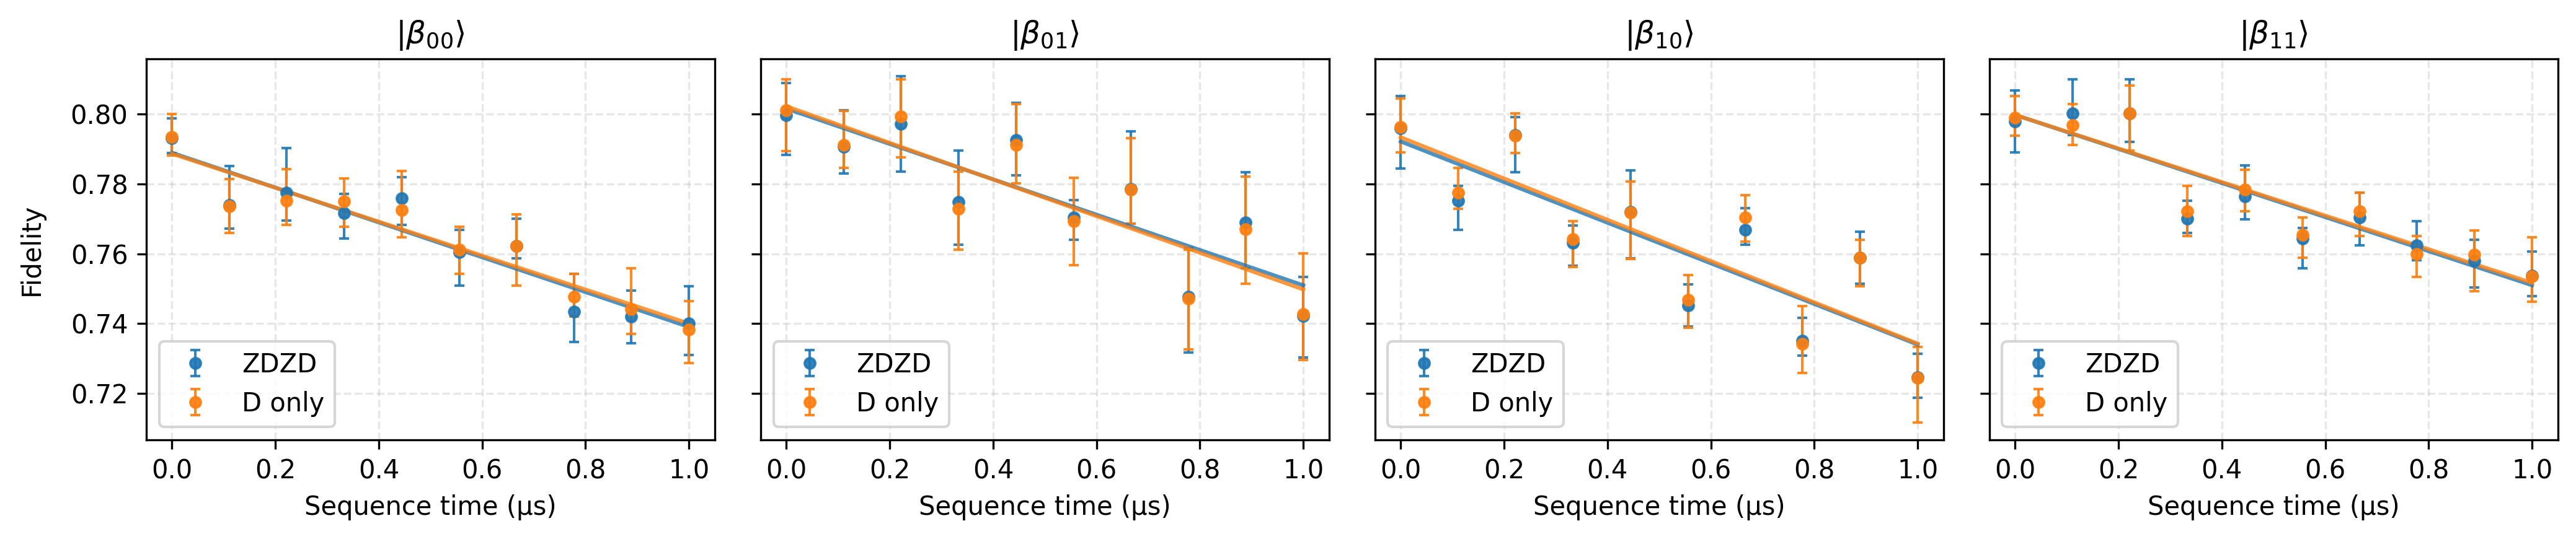

In [31]:
def line_fit(x, A, B):
    return -x/A + B

bell_labels = ["$|\\beta_{00}\\rangle$", "$|\\beta_{01}\\rangle$", "$|\\beta_{10}\\rangle$", "$|\\beta_{11}\\rangle$"]

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(14,3), constrained_layout=False, dpi=300)

axs[0].set_ylabel("Fidelity", labelpad=10)

for i in range(4):
    
    axs[i].set_title(bell_labels[i])
    axs[i].set_xlabel("Sequence time (μs)")
    
    t_ZDZD = all_wait_times[i][0]
    t_DDDD = all_wait_times[i][1]
    
    fidelity_ZDZD = avg_counts00[i][0]/shots
    fidelity_DDDD = avg_counts00[i][1]/shots
    
    # For the errorbars
    min_err_ZDZD = np.abs(fidelity_ZDZD-min_counts00[i][0]/shots)
    max_err_ZDZD = np.abs(fidelity_ZDZD-max_counts00[i][0]/shots)
    min_err_DDDD = np.abs(fidelity_DDDD-min_counts00[i][1]/shots)
    max_err_DDDD = np.abs(fidelity_DDDD-max_counts00[i][1]/shots)
    
    # Plot the data
    axs[i].errorbar(t_ZDZD, fidelity_ZDZD, yerr=[min_err_ZDZD, max_err_ZDZD],
                linewidth=0, elinewidth=1, capsize=2,
                marker="o", markeredgewidth=1, markersize=4,
                alpha=0.9,
                label="ZDZD")
    axs[i].errorbar(t_DDDD, fidelity_DDDD, yerr=[min_err_DDDD, max_err_DDDD],
                linewidth=0, elinewidth=1, capsize=2,
                marker="o", markeredgewidth=1, markersize=4,
                alpha=0.9,
                label="D only")

    # Data fitting
    fidelities_state = [fidelity_ZDZD, fidelity_DDDD]
    for k in range(2):
        state_data = fidelities_state[k]
        state_times = all_wait_times[i][k]
        model = Model(line_fit)
        params = model.make_params(A=10, B=0)
        fit_result = model.fit(state_data, params, x=state_times)
        print(i, k, fit_result.params["A"], fit_result.params["B"])
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=1.5, alpha=0.8, c=["C0", "C1"][k], ls=["solid", "--"][0])
    
    axs[i].legend(loc="lower left")
    axs[i].grid(linestyle="--", alpha=0.3, zorder=0)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_ZDZD_DD_8192Shots_errorbars_10Reps_1us_10steps_13082022_fit.pdf")  